### Determining actual neighbours in deskewed image using affine matrices

When deskewing, the actual neighbours are in the intermediated sheared image

As transformation is in the yz plane,  we determine neighbours in the sheared image and then apply inverse shear transform to find corresponding pixel values in the raw image

In [9]:
import math
import pyclesperanto_prototype as cle
from pyclesperanto_prototype._tier8._affine_transform import _determine_translation_and_bounding_box
from skimage.io import imread
import numpy as np 
#Disable scientific notation for numbers
np.set_printoptions(suppress=True)

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

original_image = imread('D:\\OneDrive - wehi.edu.au\\WEHI_projects\\Lightsheet\\pyclesperanto_prototype\\data\\RBC_tiny.tif')
original_image = original_image[::4]
voxel_size_z_in_microns = voxel_size_z_in_microns * 4
print(original_image.shape)


#Defining Deskewing transform 

scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
deskew_transform._matrix[1, 2] = shear_factor
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
deskew_transform.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)
_,deskew_transform,translation = _determine_translation_and_bounding_box(original_image, deskew_transform)

deskew_transform._matrix
deskewed = cle.affine_transform(source= original_image,transform = deskew_transform,auto_size=True)
deskewed = cle.pull(deskewed)
print(deskewed.shape)

(209, 118, 209)
(59, 1832, 209)


In [10]:
#Get shear transform
shear_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
shear_transform._matrix[1, 2] = shear_factor
print(shear_transform._matrix)

#Inverse shear transform
shear_inverse = shear_transform.copy().inverse()
print(shear_inverse._matrix)


[[1.         0.         0.         0.        ]
 [0.         1.         7.16749235 0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]
[[ 1.          0.          0.          0.        ]
 [ 0.          1.         -7.16749235  0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [11]:
#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord = shear_transform._matrix@deskew_inv_coord
print("On intermediate sheared image, coordinates are:", sheared_img_coord)


#Find neighbours in the yz plane for the sheared image
transform_yz1= cle.AffineTransform3D()
transform_yz2= cle.AffineTransform3D()
transform_yz3= cle.AffineTransform3D()
transform_yz4= cle.AffineTransform3D()

#The pixels are shifted by value equivalent to pixel size in y and z
transform_yz1.translate(translate_y=-voxel_size_y_in_microns,translate_z=-voxel_size_z_in_microns)
transform_yz2.translate(translate_y=-voxel_size_y_in_microns,translate_z=voxel_size_z_in_microns)
transform_yz3.translate(translate_y=voxel_size_y_in_microns,translate_z=-voxel_size_z_in_microns)
transform_yz4.translate(translate_y=voxel_size_y_in_microns,translate_z=voxel_size_z_in_microns)

yz1_sheared = transform_yz1._matrix@sheared_img_coord
yz2_sheared = transform_yz2._matrix@sheared_img_coord

yz3_sheared = transform_yz3._matrix@sheared_img_coord
yz4_sheared = transform_yz4._matrix@sheared_img_coord

print("Sheared image neighbour coordinates (actual neighbours)")
print("top left ", yz1_sheared)
print("top right",yz2_sheared)
print("bottom left",yz3_sheared)
print("bottom right",yz4_sheared)

#get inverse shear transform
shear_transform_inverse = shear_transform.copy().inverse()


yz1 = shear_transform_inverse._matrix@yz1_sheared
yz2 = shear_transform_inverse._matrix@yz2_sheared
yz3 = shear_transform_inverse._matrix@yz3_sheared
yz4 = shear_transform_inverse._matrix@yz4_sheared


print("Actual neighbours in the raw image")

print("top left ", yz1)
print("top right",yz2)
print("bottom left",yz3)
print("bottom right",yz4)


Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
On intermediate sheared image, coordinates are: [ 70.         420.83578736  48.11107853   1.        ]
Sheared image neighbour coordinates (actual neighbours)
top left  [ 70.         420.69079516  46.91107853   1.        ]
top right [ 70.         420.69079516  49.31107853   1.        ]
bottom left [ 70.         420.98077956  46.91107853   1.        ]
bottom right [ 70.         420.98077956  49.31107853   1.        ]
Actual neighbours in the raw image
top left  [70.         84.45599862 46.91107853  1.        ]
top right [70.         67.25401698 49.31107853  1.        ]
bottom left [70.         84.74598302 46.91107853  1.        ]
bottom right [70.         67.54400138 49.31107853  1.        ]


In [15]:
import napari
viewer = napari.Viewer()
viewer.add_image(original_image)
#viewer.add_image(deskewed)
sheared = cle.affine_transform(source= original_image,transform = shear_transform,auto_size=True)
viewer.add_image(sheared)


<Image layer 'sheared' at 0x18c8f70de20>

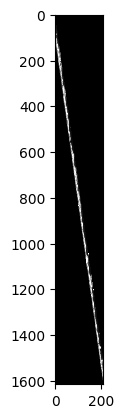

In [14]:
cle.imshow(cle.maximum_x_projection(sheared))

In [7]:
print((shear_transform_inverse._matrix[0,:]@transform_yz1._matrix)@sheared_img_coord)
print(shear_transform_inverse._matrix[1,:]@transform_yz1._matrix@sheared_img_coord)
print(shear_transform_inverse._matrix[2,:]@transform_yz1._matrix@sheared_img_coord)

print((shear_transform_inverse._matrix[0,:]@transform_yz2._matrix)@sheared_img_coord)
print(shear_transform_inverse._matrix[1,:]@transform_yz2._matrix@sheared_img_coord)
print(shear_transform_inverse._matrix[2,:]@transform_yz2._matrix@sheared_img_coord)

print((shear_transform_inverse._matrix[0,:]@transform_yz3._matrix)@sheared_img_coord)
print(shear_transform_inverse._matrix[1,:]@transform_yz3._matrix@sheared_img_coord)
print(shear_transform_inverse._matrix[2,:]@transform_yz3._matrix@sheared_img_coord)


print((shear_transform_inverse._matrix[0,:]@transform_yz4._matrix)@sheared_img_coord)
print(shear_transform_inverse._matrix[1,:]@transform_yz4._matrix@sheared_img_coord)
print(shear_transform_inverse._matrix[2,:]@transform_yz4._matrix@sheared_img_coord)

45.0
84.45599862191726
39.1781611917957
45.0
67.25401697808275
41.57816119179571
45.0
84.74598302191725
39.1781611917957
45.0
67.54400137808274
41.57816119179571


In [43]:
pix1 = original_image[47,82,70]
pix2 = original_image[49,67,70]
pix3 = original_image[47,84,70]
pix4 = original_image[49,69,70]
print(pix1,pix2,pix3,pix4)

139 219 100 255
